In [1]:
import pandas as pd

from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error,mean_absolute_error

# Statistical tests
from statistical_functions import *

# Plot functions
from plot_functions import *

# Load Data

In [2]:
df = pd.read_csv("data/monthly-milk-production-pounds-p.csv", index_col = 'Month', parse_dates=True)
df = df.asfreq('MS')
target = 'Pounds'

alpha = 0.05 #significance level

In [3]:
df.head()

,Pounds
Month,
1962-01-01,578.3
1962-02-01,609.8
1962-03-01,628.4
1962-04-01,665.6
1962-05-01,713.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 1962-01-01 to 1974-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pounds  156 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


# Plots

## Time Series

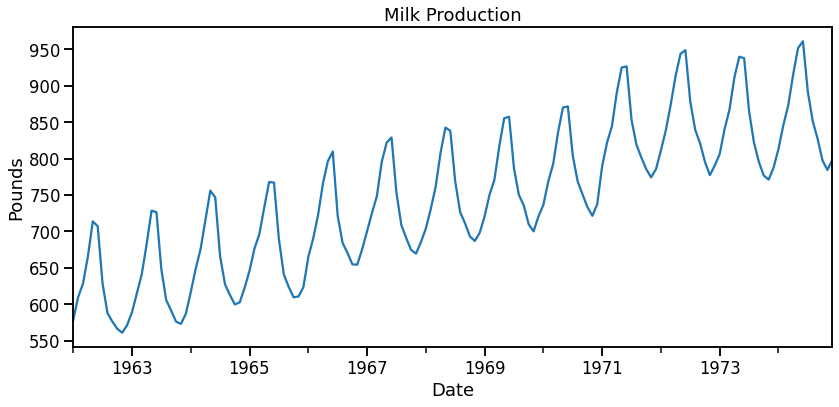

In [5]:
title = 'Milk Production'
ylabel = 'Pounds' 
xlabel = 'Date'
plot_time_series(df,target,title,ylabel,xlabel)

## Turn the time series into stationary
- Remove seasonal trend
- Remove non seasonal trend

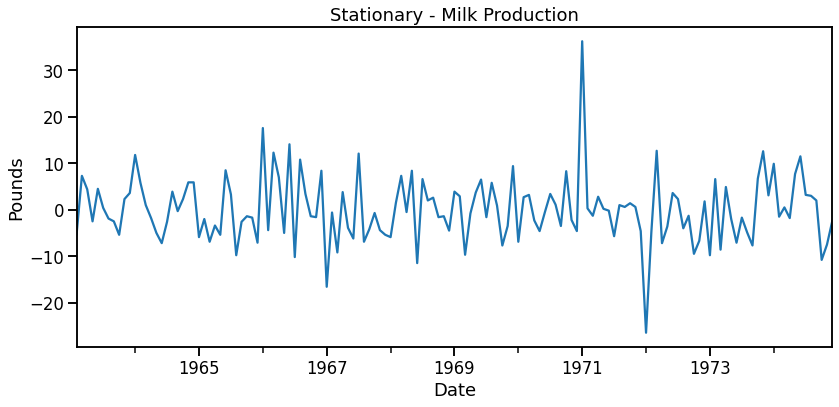

In [6]:
df_stationary = df.diff(12).dropna().diff(1).dropna() # remove seasonal (12) then non-seasonal (1) trend

title = 'Stationary - Milk Production' 
ylabel = 'Pounds' 
xlabel = 'Date'
plot_time_series(df_stationary,target,title,ylabel,xlabel)

### Perform Augmented Dickey-Fuller Test for stationarity testing on df_stationary

* H0: time series IS NOT stationary
* H1: time series IS stationary

In [7]:
adfuller_test(df_stationary[target],alpha)

Reject H0. Time series IS stationary.


ADF test statistic       -4.708718
p-value                   0.000081
# lags used              11.000000
# observations          131.000000
critical value (1%)      -3.481282
critical value (5%)      -2.883868
critical value (10%)     -2.578677
dtype: float64

## ACF and PACF
<font color ='yellow'>
Interpretation:

- The ACF indicates order of MA term q=0 and order of seasonal MA term Q <= 1
  
- The PACF indicates order of AR term p=0 and order of seasonal AR term P <= 1
  
- Seasonality s = 12
  
- d = 1 and D = 1 as we used it to make the time series stationary before the plot

-> Model: **SARIMAX(order=(0,1,0), seasonal_order=(0 or 1, 1, 0 or 1, 12))** </font>

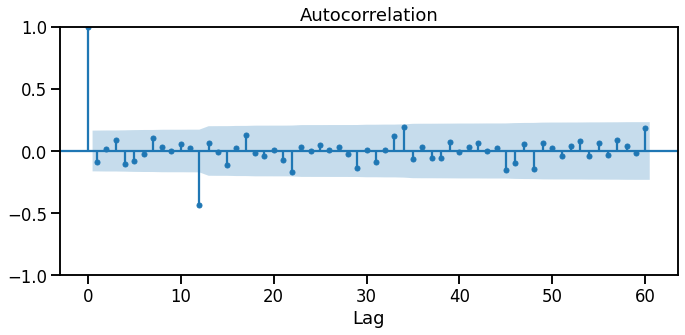

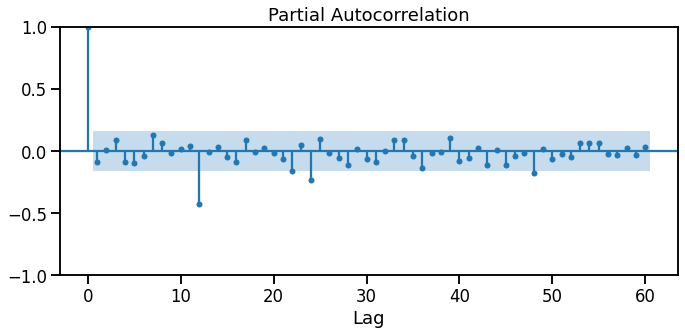

In [8]:
plot_acf_pacf(df_stationary,target,lags=60)

## Decomposition

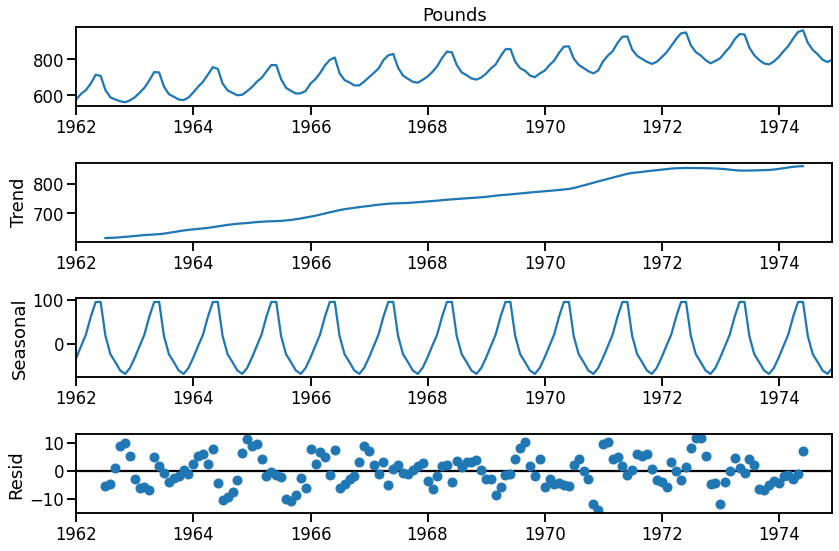

In [9]:
#ORIGINAL DF
plot_seasonal_decomposition(df,target)

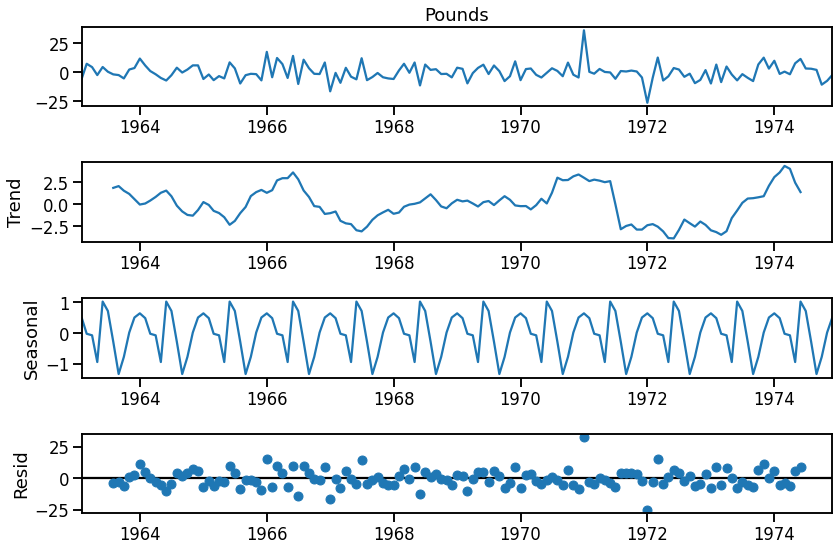

In [10]:
# DF_STATIONARY
plot_seasonal_decomposition(df_stationary,target)

# Test for correlation 

In [11]:
df_box_test = box_test(df[target],alpha)

Signifcance level: 0.05
Reject H0. There is autocorrelation at lag 1. p-value: 0.0000
Reject H0. There is autocorrelation at lag 2. p-value: 0.0000
Reject H0. There is autocorrelation at lag 3. p-value: 0.0000
Reject H0. There is autocorrelation at lag 4. p-value: 0.0000
Reject H0. There is autocorrelation at lag 5. p-value: 0.0000


# SARIMAX MODEL

## Find Best Model with auto_arima.

d = 1 and D = 1 are fixed as they make the time series stationary

In [12]:
model = auto_arima(df[target],seasonal=True,m=12,d=1,D=1)
model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -459.663
Date:                              Wed, 22 Mar 2023   AIC                            923.325
Time:                                      18:08:03   BIC                            929.251
Sample:                                  01-01-1962   HQIC                           925.733
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6750      0.074     -9.096      0.000      -0.820      -0.530
sigma2        34.4666      2.805     12.286      0.000      28.968      39.965
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               154.23
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             1.15
Prob(H) (two-sided):                  0.45   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check how this model was selected by the use of stepwise results

In [14]:
stepwise_fit = auto_arima(df[target],start_p=0, max_p=4, start_q=0, max_q=4, start_P=0,
                          max_P=2, start_Q=0, max_Q=2, d=1, D=1, seasonal=True, m=12,
                          stepwise=True, trace=True, information_criterion='aic')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=968.397, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=939.555, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=924.973, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=969.401, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=926.960, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=926.961, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=939.643, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=923.325, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=925.303, Time=0.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=925.303, Time=0.30 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=938.637, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=924.969, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AI

In [15]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -459.663
Date:                              Wed, 22 Mar 2023   AIC                            923.325
Time:                                      18:08:09   BIC                            929.251
Sample:                                  01-01-1962   HQIC                           925.733
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6750      0.074     -9.096      0.000      -0.820      -0.530
sigma2        34.4666      2.805     12.286      0.000      28.968      39.965
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               154.23
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             1.15
Prob(H) (two-sided):                  0.45   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit the best model

In [16]:
model_sarimax = SARIMAX(df[target], order=(0,1,0),seasonal_order=(0,1,1,12))
model_sarimax = model_sarimax.fit()
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Pounds   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -459.663
Date:                              Wed, 22 Mar 2023   AIC                            923.325
Time:                                      18:08:09   BIC                            929.251
Sample:                                  01-01-1962   HQIC                           925.733
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6750      0.074     -9.096      0.000      -0.820      -0.530
sigma2        34.4666      2.805     12.286      0.000      28.968      39.965
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               154.23
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             1.15
Prob(H) (two-sided):                  0.45   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Residual Analysis 

### Ljung-Box Test

In [17]:
residuals_sarimax = model_sarimax.resid

df_box_test_resid = box_test(residuals_sarimax)

Signifcance level: 0.05
Accept H0. There is NO autocorrelation at lag 1. p-value: 0.4742
Accept H0. There is NO autocorrelation at lag 2. p-value: 0.7379
Accept H0. There is NO autocorrelation at lag 3. p-value: 0.7985
Accept H0. There is NO autocorrelation at lag 4. p-value: 0.7878
Accept H0. There is NO autocorrelation at lag 5. p-value: 0.8866


### p-values for Ljung-Box statistic

<font color='yellow'>There is still some correlation between the residuals. The model does not fit well the dataset</font>

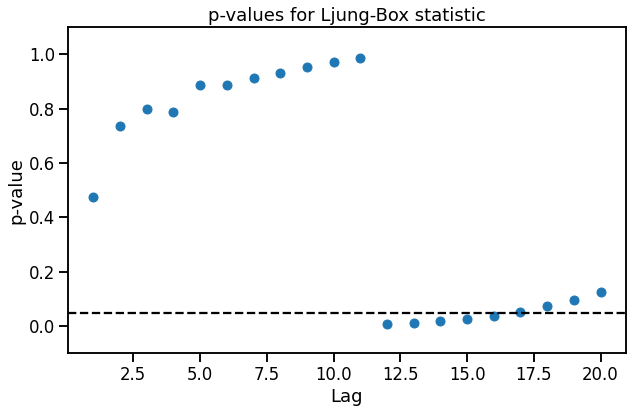

In [18]:
plot_box_test(residuals_sarimax,lag_number=20)

### Q-Q Plot

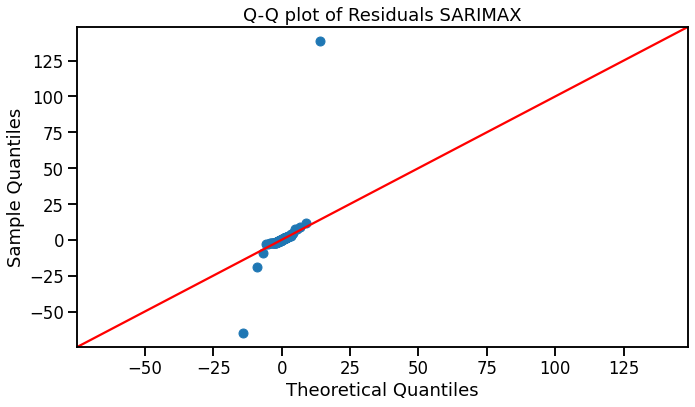

In [19]:
title= "Q-Q plot of Residuals SARIMAX"

qq_plot(residuals_sarimax,title)


### ACF

<font color='yellow'> There is autocorrelation between the residuals. The model does not do a very good job with this dataset </font>

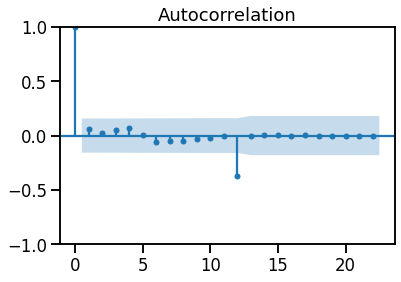

In [20]:
plot_acf(residuals_sarimax);

## Make predictions

In [21]:
predictions_sarimax = model_sarimax.predict(start=df.shape[0], end=df.shape[0]+100).rename('Predictions SARIMAX')

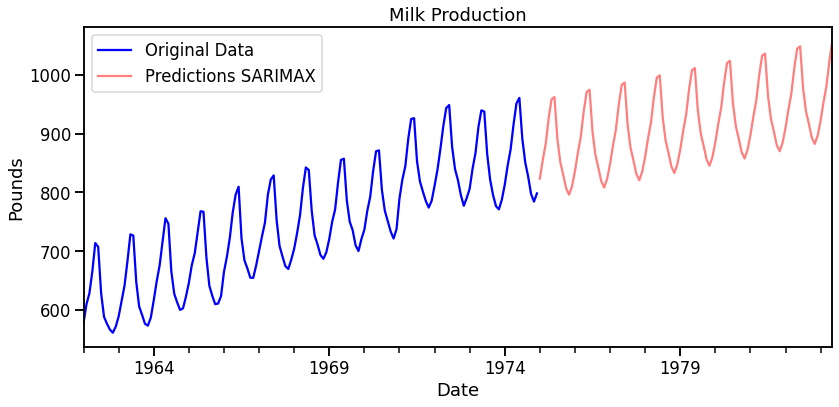

In [22]:
title = 'Milk Production' #'Total female births'
ylabel = 'Pounds' #'Number of births'
xlabel = 'Date'
fig_name = 'Time_Series_Original_and_Predicted_with_SARIMAX'
plot_time_series_and_prediction(df=df[target],df_pred=predictions_sarimax,title=title,ylabel=ylabel,
                                xlabel=xlabel,with_marker=False,save_fig=False,fig_name=fig_name)

# Holt-Winters Method

## Fit triple exponential smoothing model

In [23]:
model_hw = ExponentialSmoothing(df[target],trend='add',seasonal='add',seasonal_periods=12)
model_hw = model_hw.fit()

## Residual Analysis

<font color='yellow'> There is not correlation among the residuals. They are normally distributed, with the exception of a few outliers </font>

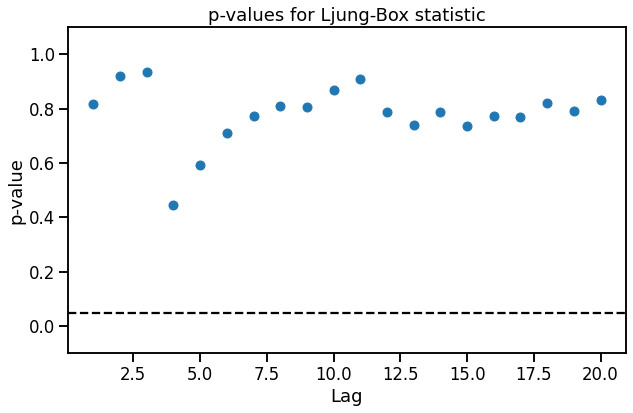

In [24]:
residuals_hw = model_hw.resid

plot_box_test(residuals_hw,lag_number=20)


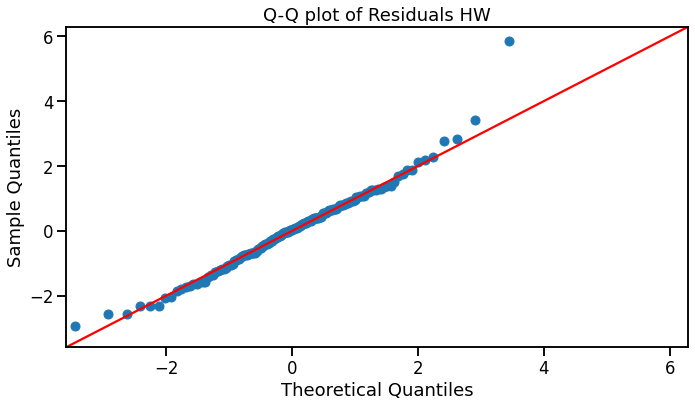

In [25]:
title= "Q-Q plot of Residuals HW"
qq_plot(residuals_hw,title)

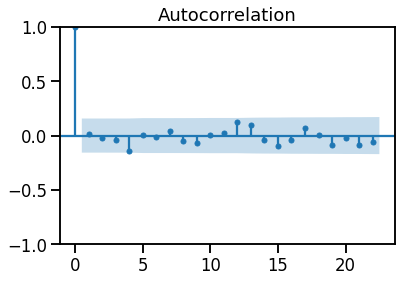

In [26]:
plot_acf(residuals_hw);

## Predictions

In [27]:
predictions_hw = model_hw.forecast(100).rename('Predictions Triple Exp Smoothing')

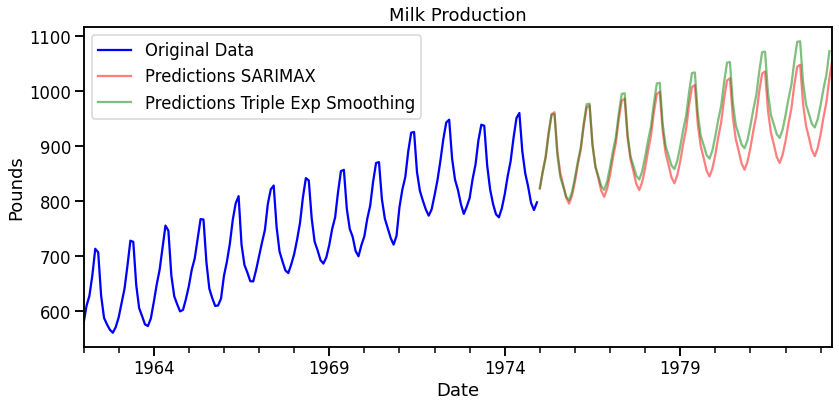

In [28]:
title = 'Milk Production' #'Total female births'
ylabel = 'Pounds' #'Number of births'
xlabel = 'Date'
plot_time_series_and_prediction(df=df[target],df_pred=predictions_sarimax,df_pred2=predictions_hw,title=title,ylabel=ylabel,
                                xlabel=xlabel,with_marker=False,save_fig=False,fig_name=fig_name)

## Plots of fitted values

In [29]:
prediction_on_train_set_hw = model_hw.fittedvalues.rename('HW')
prediction_on_train_set_sarimax = model_sarimax.fittedvalues.rename('SARIMAX')

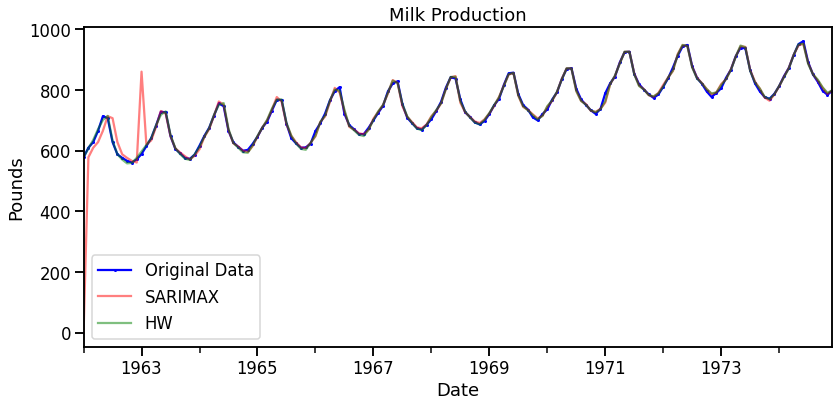

In [30]:
title = 'Milk Production' 
ylabel = 'Pounds'
xlabel = 'Date'
plot_time_series_and_prediction(df=df[target],df_pred=prediction_on_train_set_sarimax,df_pred2=prediction_on_train_set_hw,
                                title=title,ylabel=ylabel,xlabel=xlabel,with_marker=True)

# Evaluation metrics on SARIMA and HW

<font color='yellow'> What we saw on the plots so far is confirmed by the metrics. The HW model is a better fit for this dataset.</font>

In [31]:
mae_sarimax = mean_absolute_error(df[target],prediction_on_train_set_sarimax)
rmse_sarimax = mean_squared_error(df[target],prediction_on_train_set_sarimax,squared=False)

print('Errors for SARIMAX')
print(f'MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}')


Errors for SARIMAX
MAE: 11.42, RMSE: 52.29


In [32]:
mae_hw = mean_absolute_error(df[target],prediction_on_train_set_hw)
rmse_hw = mean_squared_error(df[target],prediction_on_train_set_hw,squared=False)

print('Errors for HW')
print(f'MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}')

Errors for HW
MAE: 4.06, RMSE: 5.42
